In [2]:
import numpy as np
import scipy.integrate as scp
import statistics as st
import matplotlib.pyplot as plt
import os
import multiprocessing as mp

# parameters for eps, del, the
e = 0.25
d = 0.5
t = 1

# generating balanced weight matrix
def weight_matrix_bal(matrix_size,p,q):
    mat = np.zeros((matrix_size, matrix_size))

    # sc_p = (p*10)/matrix_size
    # sc_q = (q*10)/matrix_size

    sc_p = p
    sc_q = q

    # print(sc_p)
    # print(sc_q)

    possible_vals = (-2,-1,1,2)
    weights = (1-sc_p,sc_p*((1-sc_q)/2),sc_p*((1-sc_q)/2),sc_p*sc_q)
    # print(weights)

    for i in range(matrix_size):
        for j in range(matrix_size):
            if i >= j:
                continue
            else:
                mat[i,j] = np.random.choice(possible_vals, 1, p=weights)[0]
    # print(mat)

    for i in range(matrix_size):
        for j in range(matrix_size):
            # if mat[i,j] == -2:
            #     mat[i,j] = -1-d
            #     mat[j,i] = -1-d
            if mat[i,j] == 2:
                mat[i,j] = -1+e
                mat[j,i] = -1+e
            if mat[i,j] == -2:
                mat[i,j] = -1-d
                mat[j,i] = -1-d
            if mat[i,j] == -1:
                mat[i,j] = -1-d
                mat[j,i] = -1+e
            if mat[i,j] == 1:
                mat[i,j] = -1+e
                mat[j,i] = -1-d

    # print(mat)
    return(mat)

def mat_graph(mat, matrix_size):
    mat_graph = mat.copy()

    for i in range(matrix_size):
        for j in range(matrix_size):
            if mat_graph[i,j] == -1-d:
                mat_graph[i,j] = 0
            if mat_graph[i,j] == -1+e:
                mat_graph[i,j] = 1
            # print(i,j)
    return(mat_graph)

KeyboardInterrupt: 

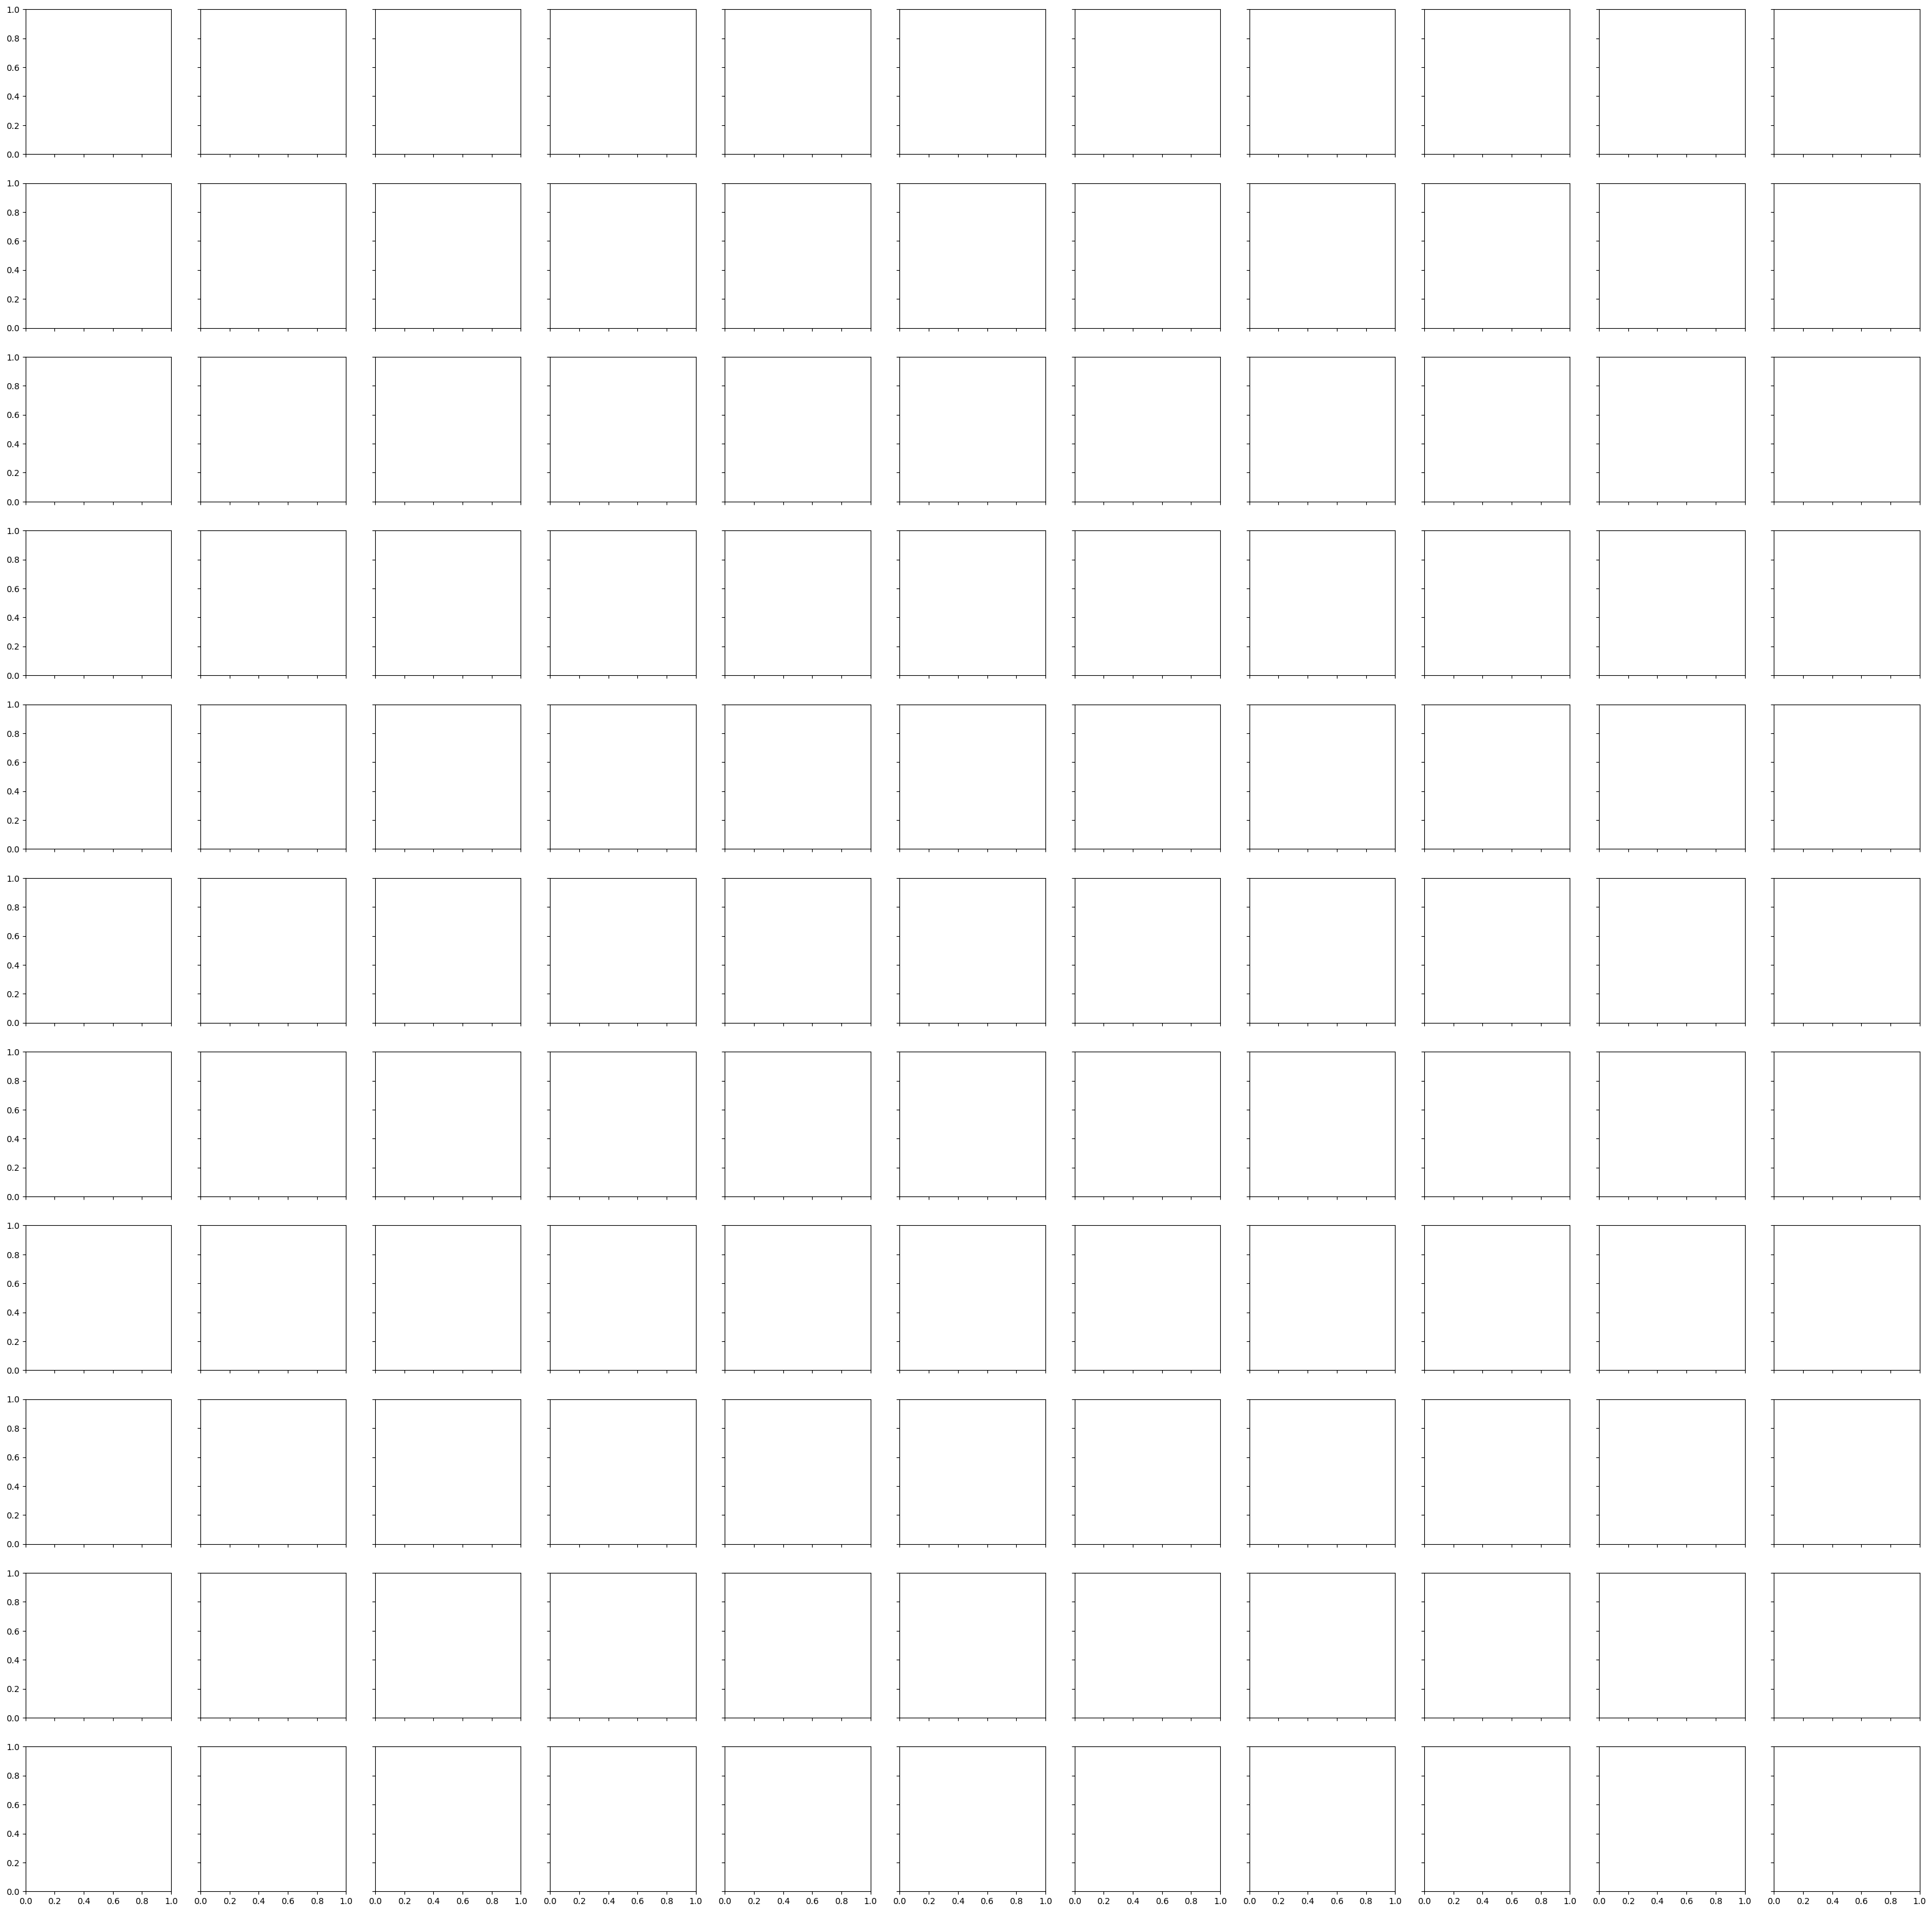

In [3]:
# Define your matrix size
mat_size = 100  
param_average = np.zeros((11,11))
p_chart = np.zeros((11,11))
q_chart = np.zeros((11,11))

fig, axs = plt.subplots(11, 11, figsize=(40,40), sharex=True, sharey=True)

# Loop over parameter values sequentially
for counter_x in range(11):
    p = round(counter_x * 0.1, 2)
    with mp.Pool(mp.cpu_count()) as pool:
        for counter_y in range(11):
            q = round(counter_y * 0.1, 2)
            trial_close = []

            for k in range(5):  # Run multiple trials per (p, q)
                W = weight_matrix_bal(mat_size, p, q)
                A = np.copy(W)  # Ensure A is defined locally for stability
                
                # Define the dynamical system
                def sys(t, x):
                    x = x.reshape(-1, 1)  # Ensure x is a column vector
                    dxdt = -x + np.maximum(0, A @ x + 1)
                    return dxdt.flatten()  # Flatten for solve_ivp
                
                # Run the solver
                x0 = np.random.rand(mat_size, 1)
                time = [0, 600]
                sol = scp.solve_ivp(sys, time, x0.flatten(), method='BDF', dense_output=False)

                # Improved fixed-point detection
                final_state = sol.y[:, -1]
                dxdt_final = sys(sol.t[-1], final_state)

                if np.all(np.abs(dxdt_final) < 1e-3):  # Check if derivatives are close to zero
                    trial_close.append(1)
                else:
                    trial_close.append(0)

        # Store results
        param_average[11 - (counter_y + 1), counter_x] = st.mean(trial_close)
        
        print(f"p = {p}, q = {q}, trial_close = {trial_close}, mean = {st.mean(trial_close)}")

        # Plot system dynamics
        u = sol.t
        v = sol.y.T
        axs[11 - (counter_y + 1), counter_x].plot(u, v)
        axs[11 - (counter_y + 1), counter_x].title.set_text(f"p = {p}, q = {q}")

        p_chart[11 - (counter_y + 1), counter_x] = p
        q_chart[11 - (counter_y + 1), counter_x] = q

# Generate heatmap
fig = plt.figure(figsize=(4, 4))
plt.imshow(param_average, cmap='RdYlBu')
plt.colorbar()
plt.xlabel('p values')
plt.ylabel('q values')
plt.title('Heatmap of Parameters')
plt.show()

# Save heatmap
filename = f'Heatmaps/Matrix_Size_{mat_size}_new_algorithm'
i = 0
while os.path.exists(f"{filename}_{i}.png"):
    i += 1

plt.savefig(f"{filename}_{i}.png", dpi=720)